In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize as opt
import math

def prepareframe(framepath):
    return pd.read_csv(framepath, header=None, delimiter='\t')

def dftobits(df):

    x1d = np.array(df[df.columns[0]])[1:]  
    df = df.drop(df.columns[0], axis=1)
    y1d = np.array(df)[0,:]  
    z2d = np.array(df)[1:,:]

    return x1d, y1d, z2d
    
def contplot(df, zlim=50):
    x1d,y1d,z2d= dftobits(df)
    
    fig= plt.figure()
    plt.contourf(x1d, y1d, z2d.transpose(), zlim,extend='both', cmap='coolwarm')
    plt.colorbar()
    fig.patch.set_facecolor('w')
    return

def maptoxyz(df):
    
    """2D map to XYZ - for fitting data"""
    
    df = np.array(df)
    X, Y, Z = [], [], []
    for i, y in enumerate(df[0][1:], 1):
        for z in df[1:]:
            X.append(z[0])
            Y.append(y)
            Z.append(z[i])
    return np.vstack((X,Y,Z))

def areaselect(framepath):
    dff = prepareframe(framepath)
    contplot(dff)
    return dff
    
def valtoindex(val, array):
    return np.abs(array-val).argmin()   

def makedf(x, y, z):    
    
    combmap = np.insert(z, 0, x, axis=1) ##builds a new dataframe from smaller bits
    y = np.insert(y, 0, 0)
    combmap = np.insert(combmap, 0, y, axis=0)

    return pd.DataFrame(combmap)

def cutdown(df, xrange, yrange):

    x1d,y1d,z2d = dftobits(df)
    x1d = x1d[:int(len(x1d)/2)]
    xlimits = (valtoindex(xrange[0], x1d), valtoindex(xrange[1], x1d))
    ylimits = (valtoindex(yrange[0], y1d), valtoindex(yrange[1], y1d))

    x1d = x1d[xlimits[0]:xlimits[1]+1]    ##cuts down bits to desired size
    y1d = y1d[ylimits[0]:ylimits[1]+1]
    z2d = z2d[xlimits[0]:xlimits[1]+1,ylimits[0]:ylimits[1]+1]
    
    return makedf(x1d,y1d,z2d)

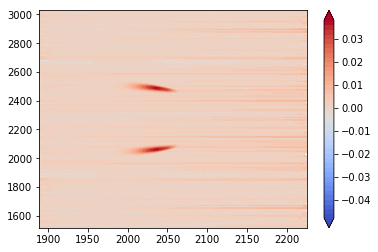

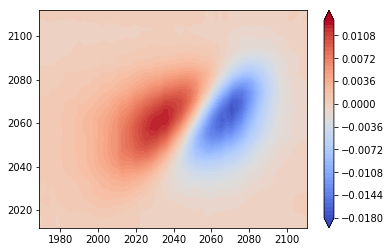

In [21]:
dff = areaselect('C:/PYTHONALL/023s/LIFE023 22C_3.000ps_2DIR.csv')
plt.show()
dfc = cutdown(dff, xrange=(1970, 2110), yrange=(2010, 2110))
contplot(dfc)

In [3]:
"""Defines 2 types of 2D Gaussians"""

def Uni_Gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6]
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    xo, yo = float(xo), float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)

    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def Bi_Gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude1, amplitude2, xo1, xo2, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8]    
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude1*np.exp( - (a*((x-xo1)**2) + 2*b*(x-xo1)*(y-yo) + c*((y-yo)**2))) \
    + amplitude2*np.exp( - (a*((x-xo2)**2) + 2*b*(x-xo2)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

In [4]:
def peaksign(signopt, data):

    """Splices data to have only positive or only negative datapoints in array."""
    
    func = Uni_Gauss
    
    if signopt == 1:
        newz=[0 if j < 0 else j for j in data]
        npnewz = np.array(newz)
        p0_in = (0.2,2030,2065,20,5,0,0)
        
    elif signopt == -1:
        newz=[0 if j > 0 else j for j in data]
        npnewz = np.array(newz)
        npnewz=-npnewz                                              ## ABSOLUTE OF NEGATIVE PEAKS FOR EASY COMP
        p0_in = (0.2,2070,2065,20,5,0,0)
    
    elif signopt == 0:
        npnewz = np.abs(data)
        p0_in = (0.2,0.15,2070,2040,2065,20,5,0,0)
        func = Bi_Gauss
        
    return npnewz, p0_in, func

In [5]:
def fitcalc(popt,pcov,time,func):
    
    std = np.sqrt(np.diag(pcov))
    
    if func is Uni_Gauss:
        popt = np.insert(popt, [1,2], [popt[0], popt[1]])
        std = np.insert(std, [1,2], [std[0], std[1]])

    sx, sy, ex, ey = abs(popt[5]), abs(popt[6]) ,std[5],std[6]
    if sx < sy:
        sx, sy, ex, ey = sy, sx, ey, ex
    
    elipticity = abs((sy)**2 - (sx)**2)/((sx)**2 + (sy)**2)
    errorelipt = ((((2*sx-sy**2)/(2*sx+sy**2))*ex)**2+(((sx**2-2*sy)/(sx**2+2*sy))*ey)**2)**0.5

    theta = popt[7] - (popt[7] // np.pi)*np.pi
    if theta > 0.5*np.pi:
        theta = np.pi - theta
    if theta < 0.25*np.pi:
        theta = 0.5*np.pi - theta
    thetaerr = std[7]                     

    igrad = 1 / math.tan(theta)
    igraderr = ((np.cos(theta))**0.5) * thetaerr                     

    arrres = (time, popt[0], popt[1], popt[2], popt[3], popt[4], sx, ex, sy, ey, elipticity,\
              errorelipt, theta, thetaerr, igrad, igraderr)
    cols = ['time','Ampl_1','Ampl_2','x0_1','x0_2','y_0', 'sigma_x', 'sigma_x_err','sigma_y',\
            'sigma_y_err', 'elipt','elipt_err', 'theta', 'theta_err', 'igrad', 'igrad_err']

    resi = pd.DataFrame(columns=cols)
    resi.loc[0]=np.array(arrres)
    resi = resi.set_index('time')

    return resi

In [6]:
def fitframe(xyzdat, signopt, time):

    """Orders processing of a single timedelay frame."""

    xy = np.append(xyzdat[0], xyzdat[1])
    
    fiterrbool = False
    
    try:
        data, p0_in, func = peaksign(signopt, xyzdat[2])
        
        popt, pcov = opt.curve_fit(f=func, xdata=xy, ydata=data, p0=p0_in, method='dogbox', maxfev=1000)
        fitraveled = func(xy, popt)

        resrow = fitcalc(popt,pcov,time,func)
        
        diff = data - fitraveled
        qfit = sum((abs(diff))/popt[0])                                         ## FIX QFIT PARAMETER
    
    except RuntimeError:
        fiterrbool = True
        print("Error - curve_fit failed")
    
    datforfig = xyzdat, fitraveled, diff

    return datforfig, resrow

In [7]:
def plotframe(df, datforfig):

    xyzdat, fitraveled, diff = datforfig
    extx = (np.min(xyzdat[0]), np.max(xyzdat[0]), np.min(xyzdat[1]), np.max(xyzdat[1]))
    
    contplot(df) 
    plt.tricontour(xyzdat[0], xyzdat[1], fitraveled, 5, extent=extx, linewidths=1, colors='k')
    plt.show()
    return
    
def plotdiff(df, datforfig):

    xyzdat, fitraveled, diff = datforfig
    x1d, y1d, z2draw = dftobits(df)

    z2d = np.reshape(diff, (len(y1d), len(x1d)))
    diffdf = makedf(x1d, y1d, z2d.transpose())
    
    contplot(diffdf)
    plt.show()
    return

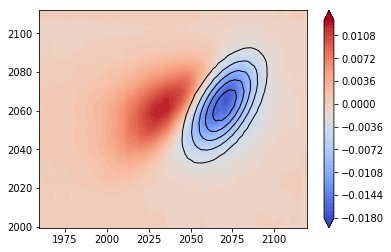

                   Ampl_1               Ampl_2               x0_1  \
time                                                                
test  0.01720411144616081  0.01720411144616081  2070.371394450166   

                   x0_2                y_0             sigma_x  \
time                                                             
test  2070.371394450166  2062.624182771896  18.513298653404807   

             sigma_x_err            sigma_y           sigma_y_err  \
time                                                                
test  0.1150469277481166  9.348371048425598  0.058123235318074784   

                   elipt            elipt_err               theta  \
time                                                                
test  0.5936522723165892  0.06988829111775102  0.9177300239957003   

                 theta_err               igrad             igrad_err  
time                                                                  
test  0.005764498270928004  0.76505

In [8]:
"""Single frame for testing"""

dffr = prepareframe('C:/PYTHONALL/023s/LIFE023 22C_3.000ps_2DIR.csv')
dfframe = cutdown(dffr, xrange=(1960, 2120), yrange=(2000, 2110))

signopt = -1
time = 'test'

xyzdat = maptoxyz(dfframe)
datforfig, resrow = fitframe(xyzdat, signopt, time)
plotframe(dfframe,datforfig)
#plotdiff(dfframe,datforfig)
print(resrow)

In [16]:
"""Run through whole dataset"""

def datasetfit(direct, signopt, showtoggle=False):
    
    import os
    paths = []
    combres = pd.DataFrame()

    for filename in os.listdir(direct):
        if filename.endswith(".csv"):
            paths.append(str(os.path.join(direct, filename)))

    for i in range(len(paths)):
        frame = paths[i]
        time = float(frame[(frame.find('_')+1):frame.find('ps')])

                                                   
        dffr = prepareframe(frame)
        dfframe = cutdown(dffr, xrange=(1970, 2110), yrange=(2010, 2110)) 
                         # xrange=(1960, 2120), yrange=(2000, 2110))     ##all prev fits done with this one

        xyzdat = maptoxyz(dfframe)
        datforfig, resrow = fitframe(xyzdat, signopt, time)
        
        combres = pd.concat([combres, resrow])                                
        
        if showtoggle is True:
            print(str(time))  
            plotframe(dfframe,datforfig) 

    combres = combres.sort_index(axis=0)
    return combres

0.0


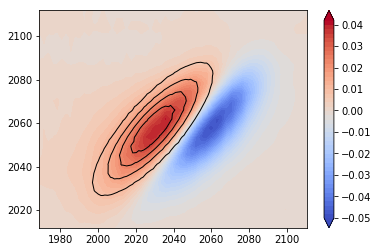

0.05


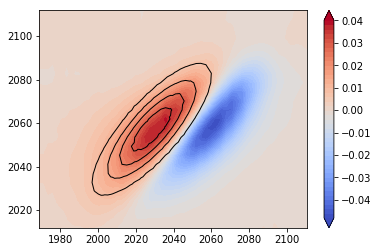

0.1


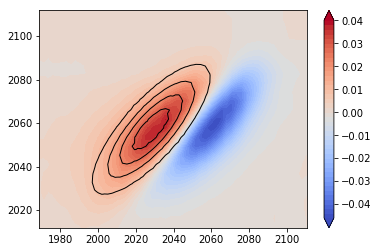

0.15


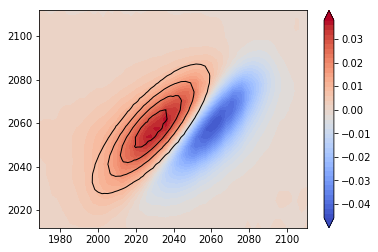

0.2


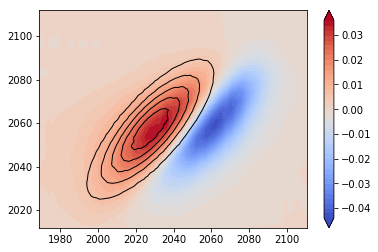

0.25


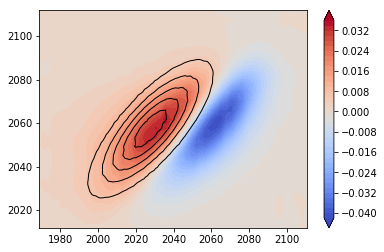

0.3


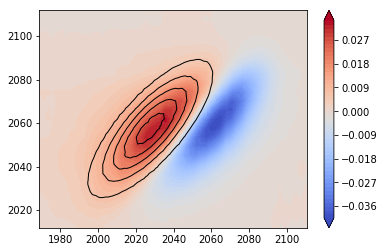

0.35


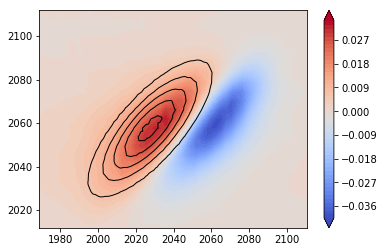

0.4


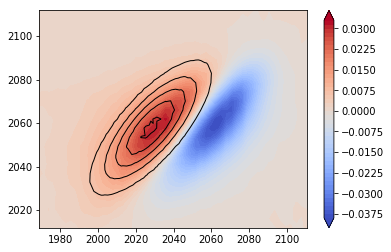

0.5


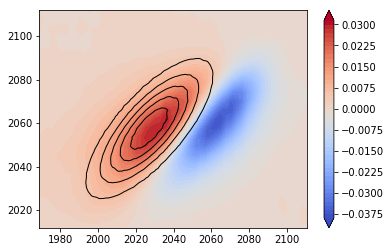

0.6


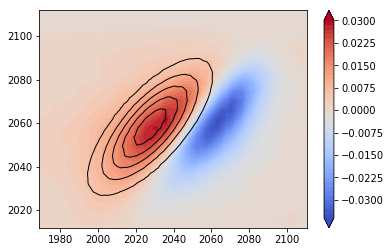

0.7


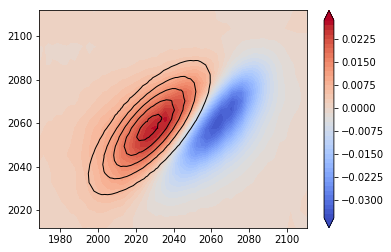

0.8


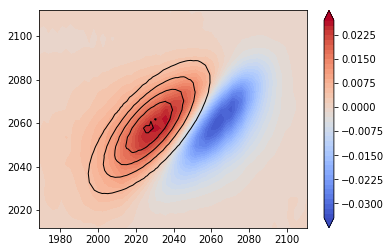

0.9


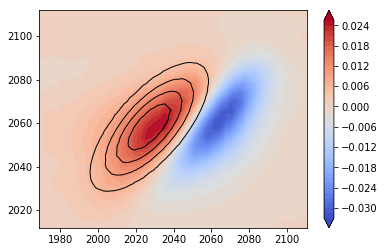

1.0


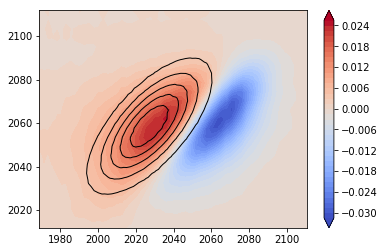

1.2


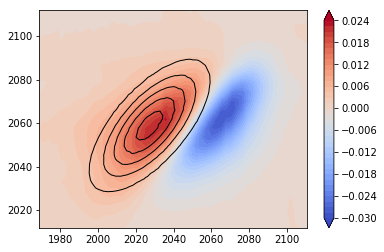

1.4


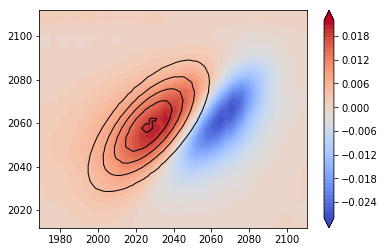

1.6


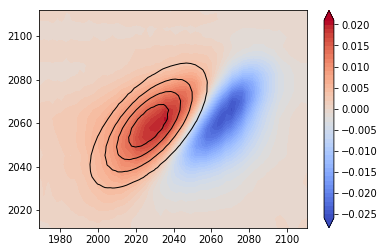

1.8


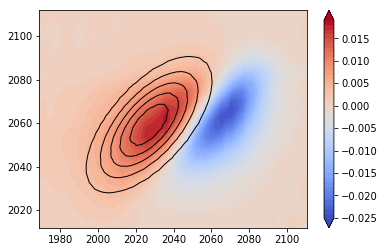

10.0


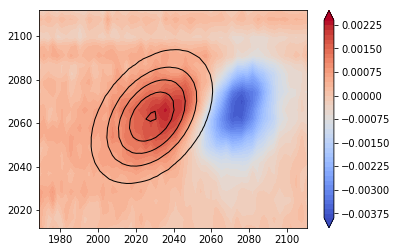

11.0


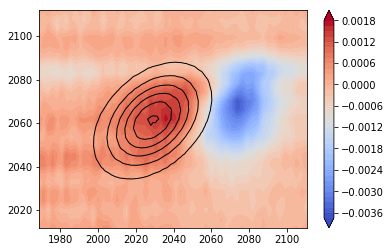

13.0


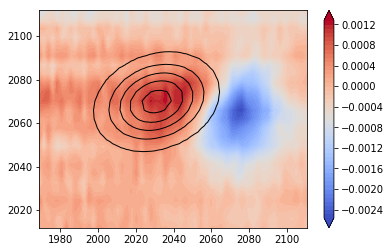

15.0


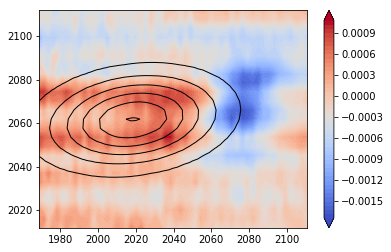

2.0


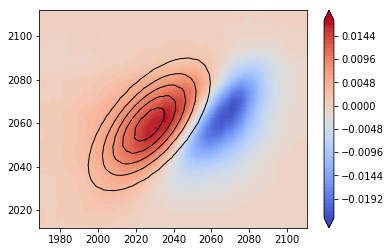

2.5


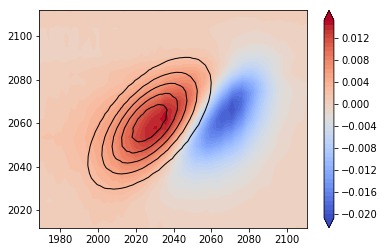

3.0


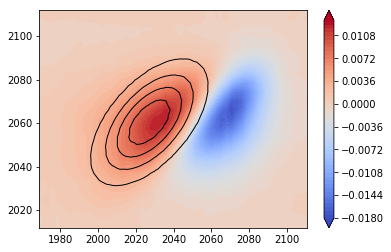

3.5


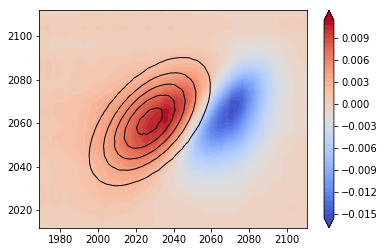

4.0


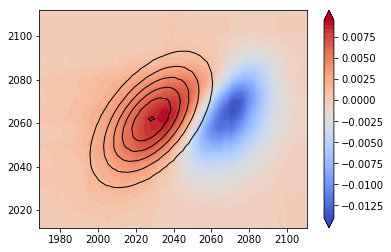

4.5


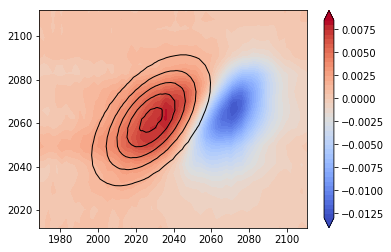

5.0


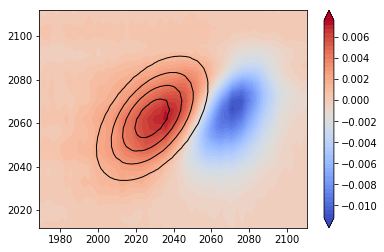

5.5


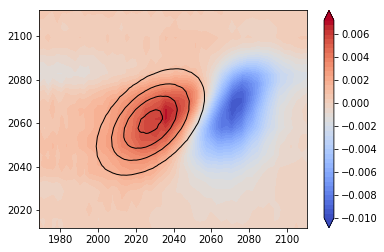

6.0


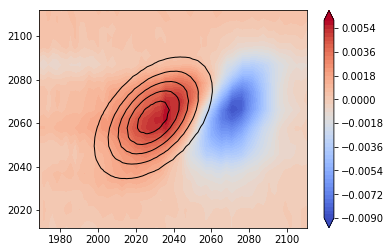

7.0


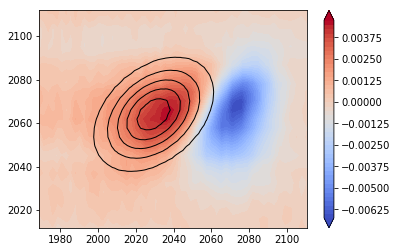

8.0


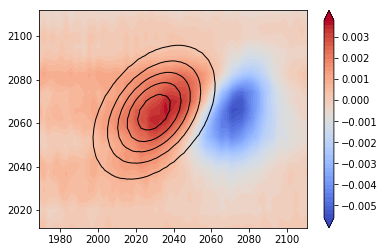

9.0


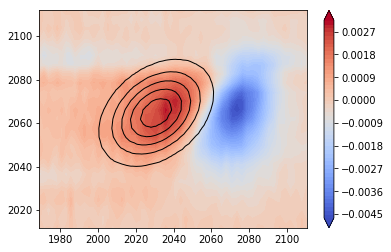

In [19]:
#res16b = datasetfit('016',0)
#res16p = datasetfit('016',1)
#res16m = datasetfit('016',-1)
res23b = datasetfit('C:/PYTHONALL/023',1, True)
#res23p = datasetfit('023',1)
#res23m = datasetfit('023',-1)

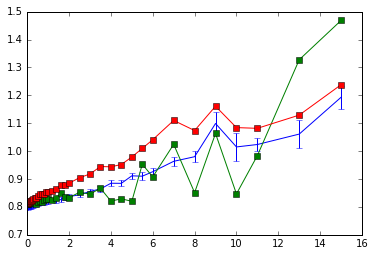

In [224]:
fig = plt.figure() 
par = 'theta'
plt.errorbar(x = res23b.index.tolist(), y = res23b[par], yerr=res23b['theta_err'])
plt.plot(res23p[par], 's-')
plt.plot(res23m[par], 's-')
#plt.xlim(0,8)
#plt.ylim(0.4,0.85)
fig.patch.set_facecolor('w')

In [51]:
combres.to_csv('testout.csv')